In [1]:
import os
import math
import pickle
import numpy as np
import tensorflow_datasets as tfds
import umap.umap_ as umap
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, initializers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import tensorflow_addons as tfa

/Users/arya/miniconda3/envs/tfenv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Collection

In [2]:
def load_style_datasets(style_name, training_split, testing_split, storage_directory='Data'):

    training_dataset = tfds.load(f"cycle_gan/{style_name}", split=training_split, as_supervised=True, shuffle_files=False,
                         data_dir=storage_directory, download=True)
    testing_dataset = tfds.load(f"cycle_gan/{style_name}", split=testing_split, as_supervised=True, shuffle_files=False,
                        data_dir=storage_directory, download=True)
    return training_dataset, testing_dataset

# Load datasets for Monet paintings
monet_datasets_style = "monet2photo"
monet_training_dataset, monet_testing_dataset = load_style_datasets(monet_datasets_style, "trainA", "testA")

# Load datasets for Ukiyo-e art
ukiyoe_datasets_style = "ukiyoe2photo"
ukiyoe_training_dataset, ukiyoe_testing_dataset = load_style_datasets(ukiyoe_datasets_style, "trainA", "testA")

# Load datasets for ordinary photographs (aligned with Ukiyo-e for contrast)
photographs_datasets_style = "ukiyoe2photo"
ordinary_photos_training_dataset, ordinary_photos_testing_dataset = load_style_datasets(photographs_datasets_style, "trainB", "testB")

## Data Combining

In [3]:
# Function to add labels to dataset
def add_labels_to_dataset(dataset, label):
    return dataset.map(lambda x, _: (x, label))

# Function to remove labels from dataset (if any)
def remove_labels_from_dataset(dataset):
    return dataset.map(lambda image, _: image)

# Function to calculate and print dataset sizes
def print_dataset_sizes(datasets, dataset_descriptions):
    for dataset, description in zip(datasets, dataset_descriptions):
        size = tf.data.experimental.cardinality(dataset).numpy()
        print(f'Size of {description}:\t{size}')

# Label definitions
label_monet = tf.constant(0, dtype=tf.int32)
label_ukiyoe = tf.constant(1, dtype=tf.int32)

# Adding labels to datasets
monet_training_dataset = add_labels_to_dataset(monet_training_dataset, label_monet)
monet_testing_dataset = add_labels_to_dataset(monet_testing_dataset, label_monet)

ukiyoe_training_dataset = add_labels_to_dataset(ukiyoe_training_dataset, label_ukiyoe)
ukiyoe_testing_dataset = add_labels_to_dataset(ukiyoe_testing_dataset, label_ukiyoe)

# Removing labels from ordinary photos datasets
ordinary_photos_training_dataset = remove_labels_from_dataset(ordinary_photos_training_dataset)
ordinary_photos_testing_dataset = remove_labels_from_dataset(ordinary_photos_testing_dataset)

In [4]:
# Combine the Monet and Ukiyo-e datasets for both training and testing
combined_monet_dataset = monet_training_dataset.concatenate(monet_testing_dataset)
combined_ukiyoe_dataset = ukiyoe_training_dataset.concatenate(ukiyoe_testing_dataset)

def combine_and_adjust_datasets(dataset_one, dataset_two):
    # Determine the smaller size between the two datasets
    size_one = tf.data.experimental.cardinality(dataset_one).numpy()
    size_two = tf.data.experimental.cardinality(dataset_two).numpy()
    smaller_size = min(size_one, size_two)
    
    # Adjust both datasets to be of the same size
    adjusted_dataset_one = dataset_one.take(smaller_size)
    adjusted_dataset_two = dataset_two.take(smaller_size)
    
    # Splitting the datasets into training and testing sets (80% training, 20% testing)
    train_size = int(smaller_size * 0.8)
    
    train_dataset_one = adjusted_dataset_one.take(train_size)
    test_dataset_one = adjusted_dataset_one.skip(train_size)
    
    train_dataset_two = adjusted_dataset_two.take(train_size)
    test_dataset_two = adjusted_dataset_two.skip(train_size)
    
    return train_dataset_one, test_dataset_one, train_dataset_two, test_dataset_two

# Applying the adjusted combine and split function
monet_train_ds, monet_test_ds, ukiyoe_train_ds, ukiyoe_test_ds = combine_and_adjust_datasets(combined_monet_dataset, combined_ukiyoe_dataset)

# Calculating and reporting dataset sizes
datasets = [monet_train_ds, monet_test_ds, ukiyoe_train_ds, ukiyoe_test_ds]
descriptions = ['Monet training', 'Monet testing', 'Ukiyo-e training', 'Ukiyo-e testing']
print_dataset_sizes(datasets, descriptions)

# Combining training and testing datasets of both styles
paintings_training_dataset = monet_train_ds.concatenate(ukiyoe_train_ds)
paintings_testing_dataset = monet_test_ds.concatenate(ukiyoe_test_ds)

# Reporting the final combined dataset sizes
final_datasets = [paintings_training_dataset, paintings_testing_dataset]
final_descriptions = ['combined training', 'combined testing']
print_dataset_sizes(final_datasets, final_descriptions)

Size of Monet training:	660
Size of Monet testing:	165
Size of Ukiyo-e training:	660
Size of Ukiyo-e testing:	165
Size of combined training:	1320
Size of combined testing:	330


## Data Preprocessing

In [5]:
IMG_SIZE = (128, 128)
BUFFER_SIZE = 10000
BATCH_SIZE = 32

def preprocess_image(image, label=None):
    # Normalize the pixel values to range from -1 to 1
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0

    # Resize the image
    image = tf.image.resize(image, IMG_SIZE)

    return (image, label) if label is not None else image

def prepare_dataset(dataset):
    # Apply preprocessing
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Preprocessing and preparing the Paintings dataset
paintings_training_dataset = prepare_dataset(paintings_training_dataset)
paintings_testing_dataset = prepare_dataset(paintings_testing_dataset)

# Preprocessing and preparing the Pictures dataset
picture_train_dataset = prepare_dataset(ordinary_photos_training_dataset)
picture_test_dataset = prepare_dataset(ordinary_photos_testing_dataset)

In [6]:
def plot_images(dataset, num_images=25):
    # Determine the grid size
    num_rows = int(math.sqrt(num_images))
    num_cols = int(math.ceil(num_images / num_rows))

    # Extract data from the first batch
    data = next(iter(dataset))

    # Check if the batch includes labels
    if isinstance(data, tuple):
        image_batch, label_batch = data
    else:
        image_batch = data
        label_batch = None

    # Randomly select a subset of images (and corresponding labels, if available)
    idx = tf.random.shuffle(tf.range(tf.shape(image_batch)[0]))[:num_images]
    image_batch = tf.gather(image_batch, idx)
    label_batch = tf.gather(label_batch, idx) if label_batch is not None else None

    # Normalize image colors to [0, 1]
    image_batch = (image_batch + 1) / 2

    # Plotting
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            ax.axis("off")
            continue
        
        img = image_batch[i].numpy()  # Convert to numpy array

        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

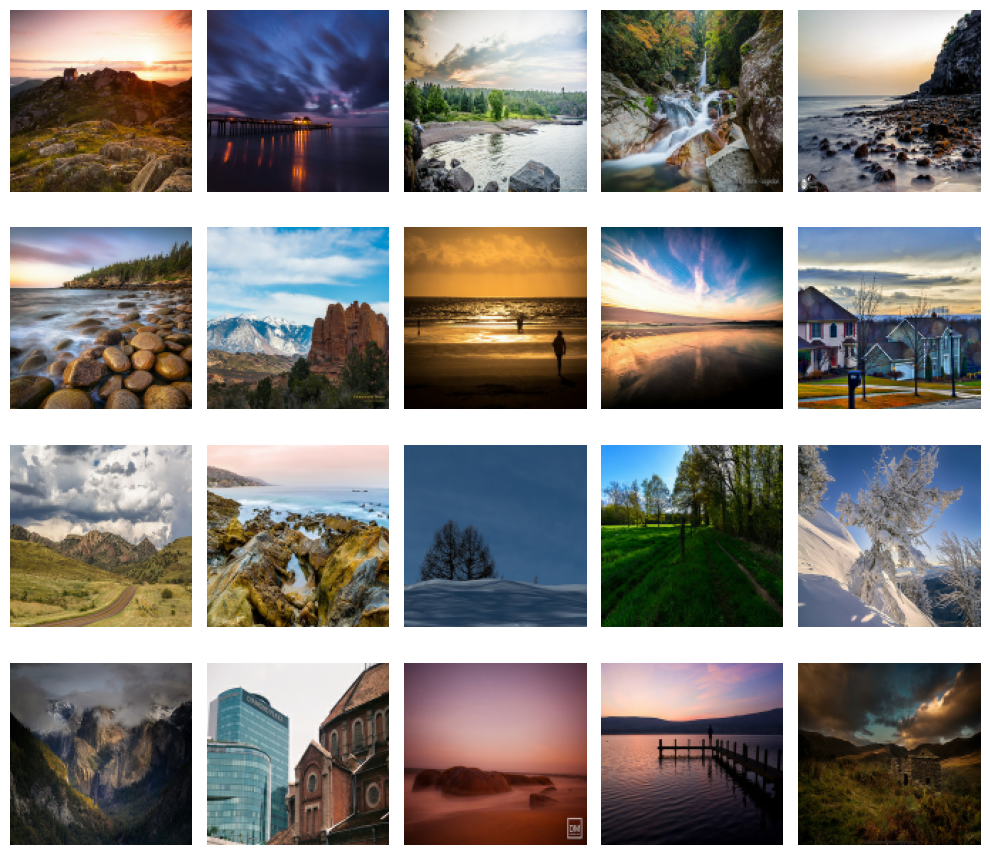

In [7]:
plot_images(picture_train_dataset, num_images=20)

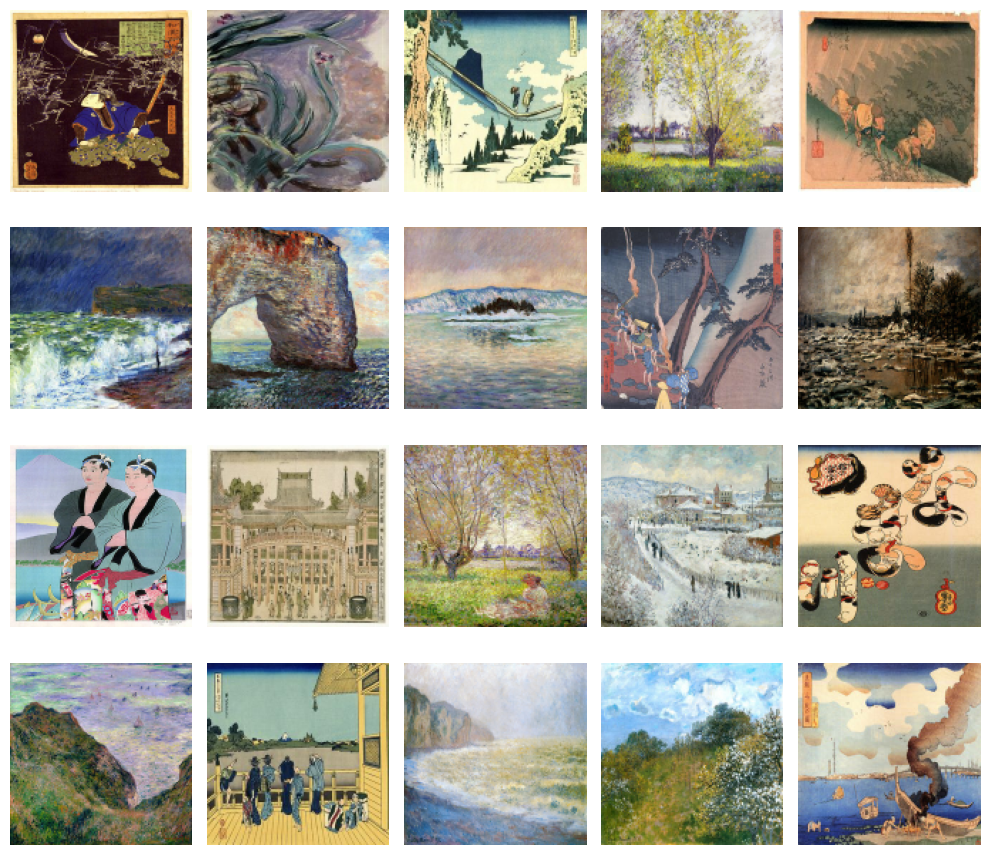

In [8]:
plot_images(paintings_training_dataset, num_images=20)

## Modeling

### Model Architecture

In [18]:
class LabelAlphaBlending(layers.Layer):
    """
    Layer that blends label embeddings for style transfer using alpha blending coefficients.
    """

    def __init__(self, **kwargs):
        super(LabelAlphaBlending, self).__init__(**kwargs)

    def build(self, input_shape):
        self.embedding_style_a = layers.Embedding(1, 50)
        self.embedding_style_b = layers.Embedding(1, 50)

        img_height, img_width = input_shape[0][1], input_shape[0][2]
        self.dense_style_a = layers.Dense(img_height * img_width)
        self.dense_style_b = layers.Dense(img_height * img_width)

    def call(self, inputs):
        input_image, input_label = inputs

        alpha = tf.reshape(input_label, (-1, 1))
        alpha_complement = tf.reshape(1 - input_label, (-1, 1))

        label_embedding_style_a = self.embedding_style_a(tf.zeros_like(alpha))
        label_embedding_style_b = self.embedding_style_b(tf.zeros_like(alpha_complement))

        label_embedding_style_a = self.dense_style_a(label_embedding_style_a)
        label_embedding_style_b = self.dense_style_b(label_embedding_style_b)

        label_embedding = alpha * label_embedding_style_a + alpha_complement * label_embedding_style_b
        label_embedding = tf.keras.layers.GlobalAveragePooling1D()(label_embedding)
        label_embedding = layers.Reshape((input_image.shape[1], input_image.shape[2], 1))(label_embedding)

        x = tf.concat([input_image, label_embedding], axis=-1)

        return x

In [19]:
def residual_block(input_tensor, input_label, filters, block_idx, concat_label=True):
    """
    Residual block for the generator network.
    """
    init_weights = initializers.RandomNormal(stddev=0.02)

    if (block_idx + 1) % 3 == 0 and concat_label:
        alpha_concat = LabelAlphaBlending(name=f'ResidualBlock_{block_idx+1}_LabelAlphaBlending')
        x = alpha_concat([input_tensor, input_label])
    else:
        x = input_tensor

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=init_weights, name=f'ResidualBlock_{block_idx+1}_Conv2D_1')(x)
    x = InstanceNormalization(axis=-1, name=f'ResidualBlock_{block_idx+1}_InstanceNorm_1')(x)
    x = layers.Activation('relu', name=f'ResidualBlock_{block_idx+1}_ReLU_1')(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=init_weights, name=f'ResidualBlock_{block_idx+1}_Conv2D_2')(x)
    x = InstanceNormalization(axis=-1, name=f'ResidualBlock_{block_idx+1}_InstanceNorm_2')(x)

    x = layers.Add(name=f'ResidualBlock_{block_idx+1}_Addition')([x, input_tensor])

    return x

In [20]:
def build_generator(input_shape, name, label_shape=(1,), num_styles=2, num_residual_blocks=9, filters=64, concat_labels_resnet=True, concat_labels_upsample=True):
    """
    Builds the generator network for the CycleGAN model.
    """
    init_weights = initializers.RandomNormal(stddev=0.02)

    input_image = layers.Input(shape=input_shape, name='ImageInput')
    input_label = layers.Input(shape=label_shape, name='LabelInput', dtype=tf.float32)

    x = LabelAlphaBlending(name='LabelAlphaBlending')([input_image, input_label])

    x = layers.Conv2D(filters, kernel_size=7, strides=1, padding='same', kernel_initializer=init_weights, name='Conv2D_1')(x)
    x = InstanceNormalization(axis=-1, name='InstanceNorm_1')(x)
    x = layers.Activation('relu', name='ReLU_1')(x)

    for i in range(2):
        filters *= 2
        x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer=init_weights, name=f'Conv2D_Encoder_{i+1}')(x)
        x = InstanceNormalization(axis=-1, name=f'InstanceNorm_Encoder_{i+1}')(x)
        x = layers.Activation('relu', name=f'ReLU_Encoder_{i+1}')(x)

    for i in range(num_residual_blocks):
        x = residual_block(x, input_label, filters, i, concat_labels_resnet)

    for i in range(2):
        filters //= 2
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', kernel_initializer=init_weights, name=f'Conv2DTranspose_Decoder_{i+1}')(x)
        x = InstanceNormalization(axis=-1, name=f'InstanceNorm_Decoder_{i+1}')(x)
        x = layers.Activation('relu', name=f'ReLU_Decoder_{i+1}')(x)
        if i == 0 and concat_labels_upsample:
            x = LabelAlphaBlending(name='LabelAlphaBlending_Upsampling')([x, input_label])

    x = layers.Conv2DTranspose(3, kernel_size=7, strides=1, padding='same', kernel_initializer=init_weights, name='Conv2DTranspose_Output')(x)
    x = InstanceNormalization(axis=-1, name='InstanceNorm_Output')(x)
    output_tensor = layers.Activation('tanh', name='TanH_Output')(x)

    return tf.keras.Model(inputs=[input_image, input_label], outputs=output_tensor, name=name)

In [21]:
def build_discriminator(input_shape, name, label_shape=(1,), num_styles=2, filters=64):
    """
    Builds the discriminator network for the CycleGAN model.
    """
    init_weights = initializers.RandomNormal(stddev=0.02)

    input_image = layers.Input(shape=input_shape, name='ImageInput')
    input_label = layers.Input(shape=label_shape, name='LabelInput')

    label_embedding = layers.Embedding(num_styles, input_shape[0] * input_shape[1], name='LabelEmbedding')(input_label)
    label_embedding = layers.Reshape(target_shape=(input_shape[0], input_shape[1], 1), name='LabelReshape')(label_embedding)
    x = layers.Concatenate(axis=-1, name='Concatenate')([input_image, label_embedding])

    x = layers.Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init_weights, name='Conv2D_1')(x)
    x = layers.LeakyReLU(alpha=0.2, name='LeakyReLU_1')(x)

    for i in range(3):
        filters *= 2
        x = layers.Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init_weights, name=f'Conv2D_{i+2}')(x)
        x = InstanceNormalization(axis=-1, name=f'InstanceNorm_{i+1}')(x)
        x = layers.LeakyReLU(alpha=0.2, name=f'LeakyReLU_{i+2}')(x)

    x = layers.Conv2D(filters, kernel_size=4, strides=1, padding='same', kernel_initializer=init_weights, name=f'Conv2D_{i+1+2}')(x)
    x = InstanceNormalization(axis=-1, name=f'InstanceNorm_{i+1+1}')(x)
    x = layers.LeakyReLU(alpha=0.2, name=f'LeakyReLU_{i+1+2}')(x)
    patch_output = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', kernel_initializer=init_weights, name='Patch_Output')(x)

    class_output = layers.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    class_output = layers.Dense(num_styles, activation='softmax', name='ClassOutput')(class_output)

    return tf.keras.Model(inputs=[input_image, input_label], outputs=[patch_output, class_output], name=name)

In [22]:
class CycleGANWithAuxClassifier(tf.keras.Model):
    """
    A Keras model implementing the Auxiliary Classifier CycleGAN architecture.
    """

    def __init__(self, generator_a2b, generator_b2a, discriminator_a, discriminator_b, num_styles, name='CycleGAN_with_AuxClassifier', lambda_cycle=10.0, lambda_identity=0.5, lambda_aux=1):
        super(CycleGANWithAuxClassifier, self).__init__(name=name)
        self.generator_a2b = generator_a2b
        self.generator_b2a = generator_b2a
        self.discriminator_a = discriminator_a
        self.discriminator_b = discriminator_b
        self.num_styles = num_styles
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.lambda_aux = lambda_aux

    def compile(self, gen_a2b_optimizer, gen_b2a_optimizer, disc_a_optimizer, disc_b_optimizer, gen_loss_fn, disc_loss_fn, aux_class_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGANWithAuxClassifier, self).compile()
        self.gen_a2b_optimizer = gen_a2b_optimizer
        self.gen_b2a_optimizer = gen_b2a_optimizer
        self.disc_a_optimizer = disc_a_optimizer
        self.disc_b_optimizer = disc_b_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.aux_class_loss_fn = aux_class_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    @tf.function
    def train_step(self, data):
        real_a, (real_b, real_b_labels) = data

        with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape:
            fake_b = self.generator_a2b([real_a, real_b_labels], training=True)
            fake_a = self.generator_b2a([real_b, real_b_labels], training=True)

            cycled_a = self.generator_b2a([fake_b, real_b_labels], training=True)
            cycled_b = self.generator_a2b([fake_a, real_b_labels], training=True)

            same_a = self.generator_b2a([real_a, real_b_labels], training=True)
            same_b = self.generator_a2b([real_b, real_b_labels], training=True)

            disc_real_a, aux_class_real_a = self.discriminator_a([real_a, real_b_labels], training=False)
            disc_real_b, aux_class_real_b = self.discriminator_b([real_b, real_b_labels], training=False)
            disc_fake_a, aux_class_fake_a = self.discriminator_a([fake_a, real_b_labels], training=False)
            disc_fake_b, aux_class_fake_b = self.discriminator_b([fake_b, real_b_labels], training=False)

            gen_a2b_loss = self.gen_loss_fn(disc_fake_b)
            gen_b2a_loss = self.gen_loss_fn(disc_fake_a)

            disc_real_a, aux_class_real_a = self.discriminator_a([real_a, real_b_labels], training=True)
            disc_real_b, aux_class_real_b = self.discriminator_b([real_b, real_b_labels], training=True)
            disc_fake_a, aux_class_fake_a = self.discriminator_a([fake_a, real_b_labels], training=True)
            disc_fake_b, aux_class_fake_b = self.discriminator_b([fake_b, real_b_labels], training=True)

            disc_a_loss = self.disc_loss_fn(disc_real_a, disc_fake_a)
            disc_b_loss = self.disc_loss_fn(disc_real_b, disc_fake_b)

            aux_class_real_a_loss = self.aux_class_loss_fn(real_b_labels, aux_class_real_a) * self.lambda_aux
            aux_class_fake_a_loss = self.aux_class_loss_fn(real_b_labels, aux_class_fake_a) * self.lambda_aux
            aux_class_real_b_loss = self.aux_class_loss_fn(real_b_labels, aux_class_real_b) * self.lambda_aux
            aux_class_fake_b_loss = self.aux_class_loss_fn(real_b_labels, aux_class_fake_b) * self.lambda_aux

            cycle_a_loss = self.cycle_loss_fn(real_a, cycled_a) * self.lambda_cycle
            cycle_b_loss = self.cycle_loss_fn(real_b, cycled_b) * self.lambda_cycle

            identity_a_loss = self.identity_loss_fn(real_a, same_a) * self.lambda_identity
            identity_b_loss = self.identity_loss_fn(real_b, same_b) * self.lambda_identity

            total_gen_a2b_loss = gen_a2b_loss + cycle_b_loss + cycle_a_loss + identity_b_loss + aux_class_fake_b_loss
            total_gen_b2a_loss = gen_b2a_loss + cycle_b_loss + cycle_a_loss + identity_a_loss + aux_class_fake_a_loss
            total_disc_a_loss = disc_a_loss + aux_class_real_a_loss + aux_class_fake_a_loss
            total_disc_b_loss = disc_b_loss + aux_class_real_b_loss + aux_class_fake_b_loss

        gen_a2b_gradients = gen_tape.gradient(total_gen_a2b_loss, self.generator_a2b.trainable_variables)
        gen_b2a_gradients = gen_tape.gradient(total_gen_b2a_loss, self.generator_b2a.trainable_variables)
        disc_a_gradients = disc_tape.gradient(total_disc_a_loss, self.discriminator_a.trainable_variables)
        disc_b_gradients = disc_tape.gradient(total_disc_b_loss, self.discriminator_b.trainable_variables)

        self.gen_a2b_optimizer.apply_gradients(zip(gen_a2b_gradients, self.generator_a2b.trainable_variables))
        self.gen_b2a_optimizer.apply_gradients(zip(gen_b2a_gradients, self.generator_b2a.trainable_variables))
        self.disc_a_optimizer.apply_gradients(zip(disc_a_gradients, self.discriminator_a.trainable_variables))
        self.disc_b_optimizer.apply_gradients(zip(disc_b_gradients, self.discriminator_b.trainable_variables))

        return (fake_b, real_b_labels), {
            "gen_a2b_loss": total_gen_a2b_loss,
            "gen_b2a_loss": total_gen_b2a_loss,
            "disc_a_loss": total_disc_a_loss,
            "disc_b_loss": total_disc_b_loss,
            "aux_class_a_loss": aux_class_real_a_loss + aux_class_fake_a_loss,
            "aux_class_b_loss": aux_class_real_b_loss + aux_class_fake_b_loss,
            "cycle_a_loss": cycle_a_loss,
            "cycle_b_loss": cycle_b_loss,
            "identity_a_loss": identity_a_loss,
            "identity_b_loss": identity_b_loss,
        }

    def call(self, inputs, training=None):
        input_image, input_label = inputs
        fake_image = self.generator_a2b([input_image, input_label], training=training)
        return fake_image

### Loss and Optimizers

In [24]:
# Binary cross-entropy loss function for the generator
def generator_loss(generated_output):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.ones_like(generated_output)))

# Binary cross-entropy loss function for the discriminator
def discriminator_loss(real_output, generated_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
    generated_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
    return real_loss + generated_loss

# Sparse categorical cross-entropy loss function for the auxiliary classifier
def aux_class_loss(labels, logits):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits))

# L1 loss function for cycle consistency loss
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# L1 loss function for identity loss
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Create a function to make a learning rate schedule that decays exponentially starting from the specified epoch
def create_lr_schedule(initial_lr, decay_start_epoch, dataset, decay_rate=0.9, staircase=False):
    steps_per_epoch = len(dataset)
    decay_steps = decay_start_epoch * steps_per_epoch
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_lr, decay_steps, decay_rate, staircase=staircase,
    )
    return lr_schedule

# Adam optimizer for the generator A2B with learning rate decay
gen_a2b_optimizer = tf.keras.optimizers.Adam(learning_rate=create_lr_schedule(0.00075, 100, paintings_training_dataset, decay_rate=0.85), beta_1=0.9)

# Adam optimizer for the generator B2A with learning rate decay
gen_b2a_optimizer = tf.keras.optimizers.Adam(learning_rate=create_lr_schedule(0.00075, 100, paintings_training_dataset, decay_rate=0.85), beta_1=0.9)

# Adam optimizer for the discriminator A with learning rate decay
disc_a_optimizer = tf.keras.optimizers.Adam(learning_rate=create_lr_schedule(1e-5, 100, paintings_training_dataset, decay_rate=0.85), beta_1=0.1)

# Adam optimizer for the discriminator B with learning rate decay
disc_b_optimizer = tf.keras.optimizers.Adam(learning_rate=create_lr_schedule(1e-5, 100, paintings_training_dataset, decay_rate=0.85), beta_1=0.1)

# Define the model's input shape and the number of styles
input_shape = (128, 128, 3)
label_shape = (1,)
num_styles = 2

# Build the generator and discriminator models
generator_a2b = build_generator(input_shape, name='Generator_A2B', label_shape=label_shape, num_styles=num_styles)
generator_b2a = build_generator(input_shape, name='Generator_B2A', label_shape=label_shape, num_styles=num_styles)
discriminator_a = build_discriminator(input_shape, name='Discriminator_A', label_shape=label_shape, num_styles=num_styles)
discriminator_b = build_discriminator(input_shape, name='Discriminator_B', label_shape=label_shape, num_styles=num_styles)

# Create the CycleGAN model with the auxiliary classifier
model = CycleGANWithAuxClassifier(
    generator_a2b, generator_b2a, discriminator_a, discriminator_b, num_styles, lambda_aux=2
)

# Compile the model with the defined loss functions and optimizers
model.compile(
    gen_a2b_optimizer, gen_b2a_optimizer, disc_a_optimizer, disc_b_optimizer, generator_loss, discriminator_loss, aux_class_loss, cycle_loss, identity_loss,
)

### Training

In [25]:
def plot_images(data, num_images=8):

    # Code to automatically define the number of rows and columns depending on the num_images
    num_rows = int(math.sqrt(num_images))
    num_cols = int(math.ceil(num_images / num_rows))

    image_batch, image_labels = data

    # Select a random subset of images from the batch
    idx = tf.random.shuffle(tf.range(image_batch.shape[0]))[:num_images]
    image_batch = tf.gather(image_batch, idx)
    image_labels = tf.gather(image_labels, idx)

    # Create a grid of images
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,6))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
          ax.imshow((image_batch[i]+1)/2)
          if image_labels[i] == 0:
              ax.set_title("Monet")
          elif image_labels[i] == 1:
              ax.set_title("Ukiyo-e")
          ax.axis("off")
    plt.tight_layout()
    plt.show()

In [26]:
# Function to plot a single photo alongside its art-style translated versions using the AC Cycle GAN model
def plot_single_translation(data,model):

    # Getting a batch of images from the test dataset
    photo_batch = next(iter(data))

    # Shuffle the images in the batch randomly
    shuffled_batch = tf.random.shuffle(photo_batch)

    # Select a random image from the shuffled batch
    image = shuffled_batch[tf.random.uniform([], minval=0, maxval=shuffled_batch.shape[0], dtype=tf.int32)]

    # The input image and label are expanded to be compatible with the model input shape.
    image = tf.expand_dims(image, axis=0)
    monet_label = tf.expand_dims(0, axis=0)
    ukiyoe_label = tf.expand_dims(1, axis=0)


    # The model is used to predict the output image based on the input image and label.
    predicted_image_monet = model.predict((image, monet_label))
    predicted_image_ukiyoe = model.predict((image, ukiyoe_label))
    # The predicted image is converted from a numpy array to a format suitable for display.
    predicted_image_monet = predicted_image_monet[0].numpy()
    predicted_image_ukiyoe = predicted_image_ukiyoe[0].numpy()
    # Rescale the predicted image to match the input image's pixel range
    predicted_image_monet = ((predicted_image_monet + 1)*127.5).astype(np.uint8)
    predicted_image_ukiyoe = ((predicted_image_ukiyoe + 1)*127.5).astype(np.uint8)


    # The original image is converted from a numpy array to a format suitable for display.
    image = image[0].numpy()
    # Rescale the original image to match the input image's pixel range
    image = ((image + 1)*127.5).astype(np.uint8)

    # Create a figure with two subplots
    fig,axs = plt.subplots(1,3,figsize=(12,4))

    # Show the original input image in the first subplot
    axs[0].imshow(image)
    axs[0].set_title('Ordinary Picture', fontsize=14)
    axs[0].axis('off')

    # Show the predicted output image in the second subplot
    axs[1].imshow(predicted_image_monet)
    axs[1].set_title('Monet Version', fontsize=14)
    axs[1].axis('off')

    axs[2].imshow(predicted_image_ukiyoe)
    axs[2].set_title('Ukiyoe Version', fontsize=14)
    axs[2].axis('off')

    plt.show()

In [27]:
def training_loop(model, max_epochs, parent_directory, folder_name, continue_training=False, save_weights=True, patience=20):

    """
    Trains the CycleGAN model.

    Parameters:
    ==========
        model (tensorflow.python.keras.engine.functional.Functional): AC CycleGAN model
        max_epochs (int): Maximum number of epochs to train the model
        parent_directory (str): Directory to save the weights and losses
        folder_name (str): Name of the folder to save the weights and losses
        continue_training (bool): Whether to continue training from a previous checkpoint or not
        save_weights (bool): Whether to save the weights after each epoch or not
        patience (int): Number of epochs with no improvement after which training will be stopped

    Returns:
    =======
        None
    """

    # Define the folder path to save the weights and losses
    folder_path = os.path.join(parent_directory, folder_name)

    # Create a new directory if it does not exist
    try:
        os.mkdir(folder_path)
    except OSError:
        pass


    if continue_training:
        # If training is being resumed, load the weights and losses from the requested epoch
        start_epoch = int(input("Enter the epoch you want to continue training from: "))

        # Calling the model with some sample input to initialize the variables
        dummy_input = (tf.zeros([1, 128, 128, 3]), tf.zeros([1, ]))
        _ = model(dummy_input,training=False)

        # Load the weights from the previous checkpoint
        model.load_weights(folder_path+f"/epoch_{start_epoch}.h5")

        # Load the saved losses
        with open(folder_path+'/epoch_losses.pickle', 'rb') as f:
            epoch_losses = pickle.load(f)

        print(f'\nContinuing training from Epoch {start_epoch}\n')

    else:
        # If starting fresh, initialize the start epoch
        start_epoch = 0

        # If starting fresh, initialize the losses dictionary
        epoch_losses = {
                            "gen_p2a_loss": [],
                            "gen_a2p_loss": [],
                            "disc_p_loss": [],
                            "disc_a_loss": [],
                            "aux_class_a_loss": [],
                            "cycle_p_loss": [],
                            "cycle_a_loss": [],
                            "identity_p_loss": [],
                            "identity_a_loss": []
                        }


    # Initialize the best loss and early stopping counter
    best_loss = float('inf')
    early_stopping_counter = 0


    # Combine the datasets
    dataset = tf.data.Dataset.zip((picture_train_dataset, paintings_training_dataset))

    # Iterating over each epoch
    for epoch in range(start_epoch,max_epochs):

        print(
                    f"\nEpoch {epoch+1}/{max_epochs}:\n"
                    "============\n"
                )

        # Dictionary to store losses for each batch in every epoch
        batch_losses = {
                            "gen_p2a_loss": [],
                            "gen_a2p_loss": [],
                            "disc_p_loss": [],
                            "disc_a_loss": [],
                            "aux_class_a_loss": [],
                            "cycle_p_loss": [],
                            "cycle_a_loss": [],
                            "identity_p_loss": [],
                            "identity_a_loss": []
                        }

        # Iterating over each batch
        for step, (real_p, (real_a, real_a_labels)) in tqdm(enumerate(dataset), total=len(dataset)):
            # Train the model on the current batch
            fake_paintings, loss_dict = model.train_step((real_p, (real_a, real_a_labels)))

            # Append the batch losses to the batch_losses dictionary
            for loss_name, loss_value in loss_dict.items():
                batch_losses[loss_name].append(loss_value.numpy())

        # Periodically after every 5 epochs
        if (epoch + 1) % 5 == 0:
            # Plot the fake painting images
            print(f"\nPlotting Images for Epoch {epoch+1}\n")
            plot_images(fake_paintings)

        # Periodically after every 10 epochs
        if (epoch + 1) % 10 == 0:

            # Plot data from test set
            print(f"\nPlotting images from Test Set\n")
            plot_single_translation(picture_test_dataset, model)

            # Save the model weights
            if save_weights:
                print(f"\nSaving weights for Epoch {epoch+1}\n")
                model.save_weights(folder_path+f'/epoch_{epoch+1}.h5')

            # Save the epoch_losses dictionary
            with open(folder_path+'/epoch_losses.pickle', 'wb') as f:
                pickle.dump(epoch_losses, f)

        # Append the mean batch losses at the end of each epoch to the epoch_losses dictionary
        for loss_name, loss_list in batch_losses.items():
            epoch_losses[loss_name].append(np.mean(loss_list))

        # Save weights if early stopping criteria is met
        if epoch_losses['gen_p2a_loss'][epoch] < best_loss:
            # Save the new best weights
            best_loss = epoch_losses['gen_p2a_loss'][epoch]
            early_stopping_counter = 0
            model.save_weights(folder_path+f'/best_generator_p2a_loss.h5')
        # Increment counter if not
        else:
            early_stopping_counter += 1


        # Print the losses periodically at the end of each epoch
        print(
                    f"\nLosses:\n"
                    "-------\n"
                    f"Photo to Art Generator Loss\t=\t{epoch_losses['gen_p2a_loss'][epoch]:.4f}\n"
                    f"Art to Photo Generator Loss\t=\t{epoch_losses['gen_a2p_loss'][epoch]:.4f}\n"
                    f"Photo Discriminator Loss\t=\t{epoch_losses['disc_p_loss'][epoch]:.4f}\n"
                    f"Art Discriminator Loss\t\t=\t{epoch_losses['disc_a_loss'][epoch]:.4f}\n"
                    f"Art Auxiliary Classifier Loss\t=\t{epoch_losses['aux_class_a_loss'][epoch]:.4f}\n"
                    f"Photo Cycle Loss\t\t=\t{epoch_losses['cycle_p_loss'][epoch]:.4f}\n"
                    f"Art Cycle Loss\t\t\t=\t{epoch_losses['cycle_a_loss'][epoch]:.4f}\n"
                    f"Photo Identity Loss\t\t=\t{epoch_losses['identity_p_loss'][epoch]:.4f}\n"
                    f"Art Identity Loss\t\t=\t{epoch_losses['identity_a_loss'][epoch]:.4f}\n"
                )
        print('-'*30)
        print('\n')

        # Break the loop if loss doesn't decrese for more than patient epochs
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}.")
            break

    print("Training complete")

In [28]:
parent_directory = "ModelWeights/"
folder_name = "Final_Weights"

In [ ]:
training_loop(
                model,
                max_epochs = 300,
                parent_directory = parent_directory,
                folder_name = folder_name,
                continue_training = False,
                save_weights = True
             )

## Model Evaluation

In [ ]:
# Loading the Epoch Losses disctionary
with open(parent_directory+folder_name+'/epoch_losses.pickle', 'rb') as f:
            epoch_losses = pickle.load(f)

In [ ]:
# Creating the figure and axis objects for the plot
fig,ax = plt.subplots(figsize=(12,7))

# Setting the grid properties
ax.grid(color='#adadad',axis='both',which='major',linestyle='--',alpha=0.5,zorder=-1)

# Setting the properties of the plot border
plt.setp(ax.spines.values(), linewidth=2, color='k')

epochs = range(1, len(epoch_losses["gen_p2a_loss"]) + 1)

# Plot the losses for each epoch
plt.plot(epochs, epoch_losses["gen_p2a_loss"], lw=3.5, label="Photo to Art Generator Loss")
plt.plot(epochs, epoch_losses["gen_a2p_loss"], lw=3.5, label="Art to Photo Generator Loss")
plt.plot(epochs, epoch_losses["disc_p_loss"], lw=3.5, label="Photo Discriminator Loss")
plt.plot(epochs, epoch_losses["disc_a_loss"], lw=3.5, label="Art Discriminator Loss")
plt.plot(epochs, epoch_losses["aux_class_a_loss"], lw=3.5, label="Art Auxiliary Classifier Loss")
plt.plot(epochs, epoch_losses["cycle_p_loss"], lw=3.5, label="Photo Cycle Loss")
plt.plot(epochs, epoch_losses["cycle_a_loss"], lw=3.5, label="Art Cycle Loss")
plt.plot(epochs, epoch_losses["identity_p_loss"], lw=3.5, label="Photo Identity Loss")
plt.plot(epochs, epoch_losses["identity_a_loss"], lw=3.5, label="Art Identity Loss")

# Setting the properties of the ticks on both the axes
ax.tick_params(axis='both', which='major',labelcolor='k',labelsize=14, length=0)

# Setting the labels for the x and y axes
ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('Losses',fontsize=18)

# Plotting the legend
legend = ax.legend(handleheight=1,handlelength=2)
# Setting up the legend properties
legend.set_title('Type of Loss')
legend.get_title().set_fontsize(14)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_facecolor('None')
[text.set_fontsize(12) for text in legend.get_texts()]

# Setting the title
ax.set_title('Loss Plot',fontsize=22)

plt.show()

In [ ]:
# Creating an AC Cycle GAN model using the class created above
model = AuxiliaryClassifierCycleGAN(generator_p2a, generator_a2p, discriminator_p, discriminator_a, num_classes)

# Compiling the AC Cycle GAN
model.compile(
    gen_p2a_optimizer,
    gen_a2p_optimizer,
    disc_p_optimizer,
    disc_a_optimizer,
    generator_loss,
    discriminator_loss,
    auxiliary_classification_loss,
    cycle_consistency_loss,
    identity_loss,
)

# Calling the model with some sample input to initialize the variables
dummy_input = (tf.zeros([1, 128, 128, 3]), tf.zeros([1, ]))
_ = model(dummy_input,training=False)

# Loading model weights
model.load_weights(parent_directory+folder_name+'/best_generator_p2a_loss.h5')

In [ ]:
# Function to plot a multiple photos alongside translated versions of both art-styles using the AC Cycle GAN model
def plot_generated_images(dataset, num_images=6, num_columns=6, separation=True):

    # Calculate the number of rows needed based on the number of images and columns
    num_rows = (num_images * 3) // num_columns

    if (num_images * 3) % num_columns != 0:
        num_rows += 1

    # Get a batch of images from the dataset
    data = next(iter(dataset))

    # Randomly select a subset of images from the batch
    idx = tf.random.shuffle(tf.range(data.shape[0]))[:num_images]
    image_batch = tf.gather(data, idx)

    # Generate Ukiyo-e and Monet-style images for the batch
    ukiyo_e_images = model.predict((image_batch, tf.ones((image_batch.shape[0]))))
    monet_images = model.predict((image_batch, tf.zeros((image_batch.shape[0]))))

    # Create a plot with the specified number of rows and columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 10))

    # Loop over each row and column in the plot and add the corresponding image
    for row in range(num_rows):
        for col in range(num_columns):

            index = (row * num_columns + col) // 3
            style = (row * num_columns + col) % 3

            if col % 3 == 0:
                # Original image
                axs[row, col].imshow((image_batch[index] + 1) / 2)
                if row == 0:
                    axs[row, col].set_title('Ordinary Pictures',fontsize=18)
            elif col % 3 == 1:
                # Ukiyo-e style generated image
                axs[row, col].imshow((monet_images[index] + 1) / 2)
                if row == 0:
                    axs[row, col].set_title('Monet versions',fontsize=18)
            elif col % 3 == 2:
                # Monet style generated image
                axs[row, col].imshow((ukiyo_e_images[index] + 1) / 2)
                if row == 0:
                    axs[row, col].set_title('Ukiyo-e versions',fontsize=18)

            axs[row, col].axis('off')

    # Redraw the canvas to update the plot
    fig.canvas.draw()

    # Add a vertical line between the two subplot groups
    if separation:
        line = fig.add_artist(plt.Line2D([0.5, 0.5], [0, 0.95], color='k', lw=3, ls='--'))

    # Add a title to the plot and adjust the layout
    fig.suptitle("Original Photographs and Generated Paintings", y=1, fontsize=28, fontweight='bold')
    fig.tight_layout()

    # Show the plot
    plt.show()

    # Plotting the images from the test data
plot_generated_images(picture_test_dataset)